In [1]:
import os

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

from matplotlib import pyplot as plt
plt.style.use("bmh")

In [2]:
ws_dir = "/root/labrador-evaluation/ws"

fn_q = os.path.join(ws_dir, "FastChat/fastchat/llm_judge/data/pr_bench/question.jsonl")
df_q = pd.read_json(fn_q, lines=True)
print(f"{len(df_q)=}")

fn_q_old = os.path.join(ws_dir, "FastChat/fastchat/llm_judge/data-old/pr_bench/question.jsonl")
df_q_old = pd.read_json(fn_q_old, lines=True)
print(f"{len(df_q_old)=}")

fn_j = os.path.join(ws_dir, "FastChat/fastchat/llm_judge/data/pr_bench/model_judgment/gpt-4_single.jsonl")
df_j = pd.read_json(fn_j, lines=True)
print(f"{len(df_j)=}")

len(df_q)=138
len(df_q_old)=13
len(df_j)=1380


In [3]:
df_q_diff = df_q[~df_q['qna_fn'].isin(df_q_old["qna_fn"].to_list())]

df_q_diff.head()

,qna_fn,question_id,category,turns,reference
0,/root/labrador-evaluation/ws/taxonomy/compositional_skills/extraction/inference/quantitative/beancount/qna.yaml,0,taxonomy,[Record the following in a Beancount ledger: I spent 80 EUR in cash on groceries.],"[2024-01-01 * ""Buying groceries""\n Expenses:Food:Groceries 80.00 EUR\n Assets:Cash\n]"
1,/root/labrador-evaluation/ws/taxonomy/compositional_skills/extraction/inference/quantitative/beancount/qna.yaml,1,taxonomy,[Record the following in a Beancount ledger: I spent 40.15 EUR in cash on groceries.],"[2024-01-01 * ""Buying groceries""\n Expenses:Food:Groceries 40.15 EUR\n Assets:Cash\n]"
2,/root/labrador-evaluation/ws/taxonomy/compositional_skills/extraction/inference/quantitative/beancount/qna.yaml,2,taxonomy,[Record the following in a Beancount ledger: I spent 120.56 EUR in cash on groceries.],"[2024-01-01 * ""Buying groceries""\n Expenses:Food:Groceries 120.56 EUR\n Assets:Cash\n]"
3,/root/labrador-evaluation/ws/taxonomy/compositional_skills/extraction/inference/quantitative/beancount/qna.yaml,3,taxonomy,[Record the following in a Beancount ledger: I paid 40 EUR in cash in the restaurant.],"[2024-01-01 * ""Restaurant""\n Expenses:Food:Restaurant 40.00 EUR\n Assets:Cash\n]"
4,/root/labrador-evaluation/ws/taxonomy/compositional_skills/extraction/inference/quantitative/beancount/qna.yaml,4,taxonomy,[Record the following in a Beancount ledger: I paid 12.15 EUR at the bakery.],"[2024-01-01 * ""Bakery""\n Expenses:Food:Bakery 12.15 EUR\n Assets:Cash\n]"


In [44]:
print(len(df_q_diff["qna_fn"].unique()), len(df_q_diff["qna_fn"]))

df_q_diff.groupby("qna_fn").size().value_counts().reset_index().rename({"index": "#examples"}, axis=1)

22 125


,#examples,count
0,3,7
1,4,5
2,6,2
3,5,2
4,13,1
5,15,1
6,9,1
7,10,1
8,7,1
9,8,1


In [16]:
df_j_diff.groupby("model")["score"].mean().reset_index()

,model,score
0,merlinite-7b,5.8672
1,merlinite-7b-rc,5.8824


In [4]:
df_j_diff = df_j.merge(df_q_diff, on="question_id", how="inner")
df_j_diff['model'] = df_j_diff['model'].str.replace('-[0-9]$', '', regex=True)
df_j_diff['qna_fn'] = df_j_diff['qna_fn'].str.replace('/root/labrador-evaluation/ws/taxonomy/', '')
df_j_diff['qna_fn'] = df_j_diff['qna_fn'].str.replace('/qna.yaml', '')
df_g = df_j_diff.groupby(['qna_fn', 'model'])["score"].mean().unstack(fill_value=0)

df_g.head()

model,merlinite-7b,merlinite-7b-rc
qna_fn,,
compositional_skills/extraction/inference/quantitative/beancount,5.113333,7.393333
compositional_skills/extraction/inference/quantitative/punctuation_count,2.753846,3.138462
compositional_skills/extraction/inference/quantitative/table_manipulation,3.450000,3.250000
compositional_skills/extraction/information/debug/stacktrace,7.133333,4.066667
compositional_skills/extraction/information/development/linux/page_size,8.466667,7.466667


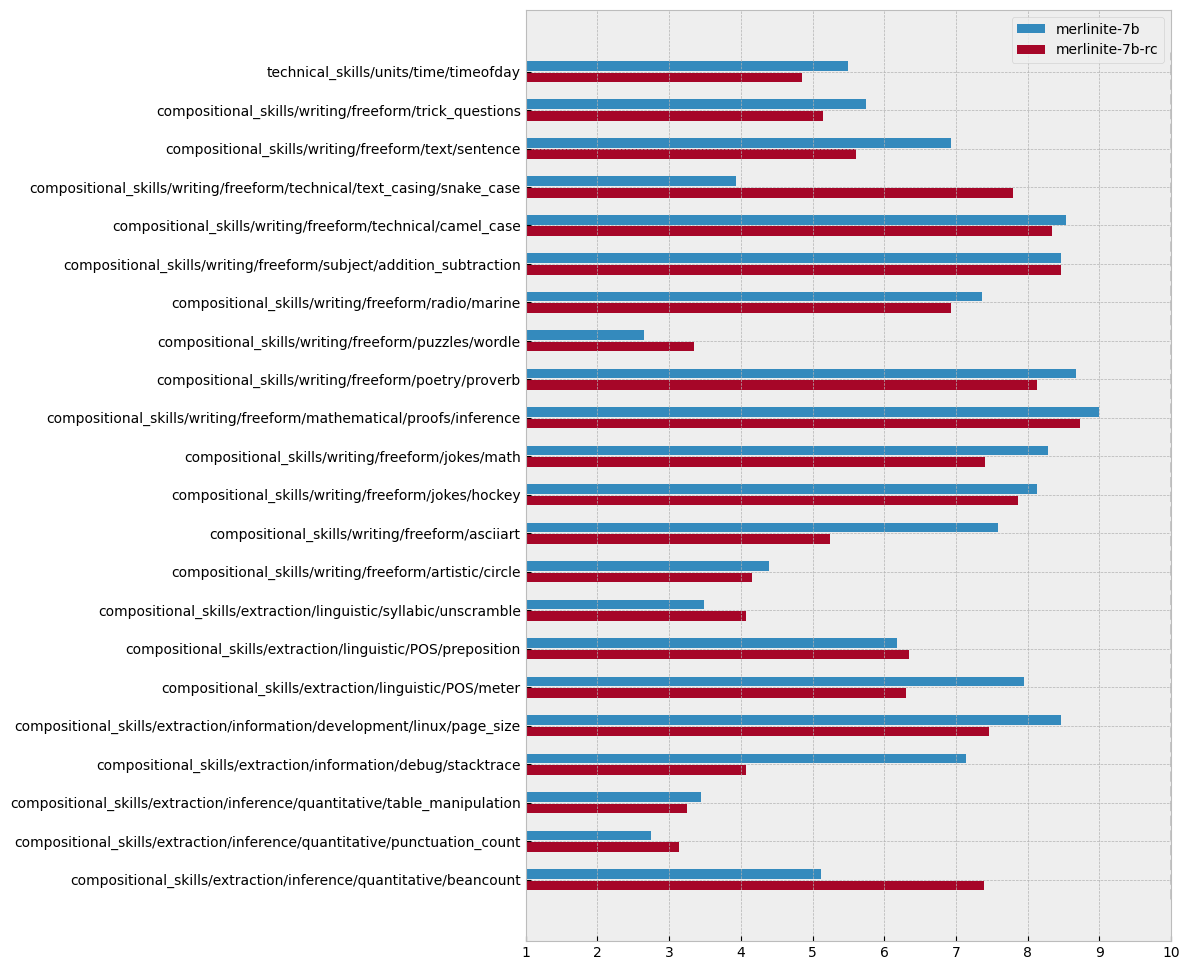

In [21]:
def make_fig(df_g, ths=10):
    df_gg = df_g[df_g["merlinite-7b"]<ths]
    n = df_gg.shape[0]
    
    fig, ax = plt.subplots(figsize=(12, 0.4 * n + 1), tight_layout=True)
    plt.close(fig)
    
    y = list(range(n))
    y0 = [yi + 0.15 for yi in y]
    y1 = [yi - 0.15 for yi in y]
    ax.vlines(ths, y[0] - 0.5, y[-1] + 0.5, color="gray", linestyle="dashed", alpha=0.4)
    for yi, m in zip([y0, y1], ["merlinite-7b", "merlinite-7b-rc"]):
        ax.barh(yi, df_gg[m].to_list(), label=m, height=0.25)
    ax.set_xlim(1, 10)
    ax.set_yticks(y, df_gg.index.to_list())
    ax.legend()
    
    return fig

make_fig(df_g)

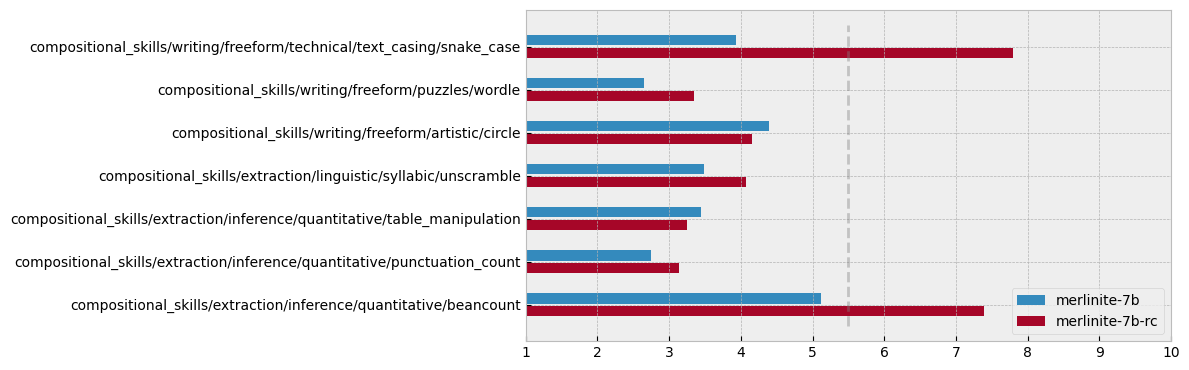

In [45]:
make_fig(df_g, 5.5)

In [48]:
fn_q = os.path.join(ws_dir, "FastChat/fastchat/llm_judge/data/mt_bench/question.jsonl")
df_q = pd.read_json(fn_q, lines=True)
print(f"{len(df_q)=}")

fn_j = os.path.join(ws_dir, "FastChat/fastchat/llm_judge/data/mt_bench/model_judgment/gpt-4_single.jsonl")
df_j = pd.read_json(fn_j, lines=True)
print(f"{len(df_j)=}")

len(df_q)=80
len(df_j)=1600


In [53]:
df_j['model'] = df_j['model'].str.replace('-[0-9]$', '', regex=True)

df_j.groupby("model")["score"].mean()

model
merlinite-7b       7.569375
merlinite-7b-rc    7.555000
Name: score, dtype: float64